<a href="https://colab.research.google.com/github/AliciaFalconCaro/MedicalImageClassificationExample/blob/main/MedicalimageClassificationSVM_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will perform some basic medical image classification techniques.
The purpose is to compare traditional techniques with DL techniques.

For this mini-project, we will use the public dataset available here: https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic/data

The dataset is already separated in two folders: train and test. It contains multiple images from different skin cancers. In total, there are 6 classes of cancer in the dataset.

Let's start with loading the data and having a quick look at it

In [1]:
import os
import cv2
import numpy as np
import pandas as pd

# Function to load images and labels
def load_data_from_folder(base_dir, img_size=(64, 64)): #size to be changed if necessary. (64,64) is more common. The other size (600,450) is the actual size of the average images in the folder, but it takes too long
    images = []
    labels = []
    label_map = {}  # Mapping folder names to numeric labels
    current_label = 0

    for label_name in sorted(os.listdir(base_dir)):  # Sort for consistent ordering
        label_path = os.path.join(base_dir, label_name)
        if os.path.isdir(label_path):  # Ensure it's a folder
            label_map[label_name] = current_label
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                # Read the image
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, img_size)  # Resize to consistent size
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB (OpenCV is BGR by default)
                    images.append(img)
                    labels.append(current_label)  # Append numeric label
            current_label += 1

    return np.array(images), np.array(labels), label_map

# Load the data (it will be resized)
X_train, y_train, train_label_map = load_data_from_folder('./local_dir/Skin_Cancer_ISIC_Data/Train')
X_test, y_test, test_label_map = load_data_from_folder('./local_dir/Skin_Cancer_ISIC_Data/Test')

print(f"Training data: {X_train.shape}, Labels: {y_train.shape}")
print(f"Test data: {X_test.shape}, Labels: {y_test.shape}")
print(f"Label Map: {train_label_map}")

Training data: (2239, 64, 64, 3), Labels: (2239,)
Test data: (118, 64, 64, 3), Labels: (118,)
Label Map: {'actinic keratosis': 0, 'basal cell carcinoma': 1, 'dermatofibroma': 2, 'melanoma': 3, 'nevus': 4, 'pigmented benign keratosis': 5, 'seborrheic keratosis': 6, 'squamous cell carcinoma': 7, 'vascular lesion': 8}


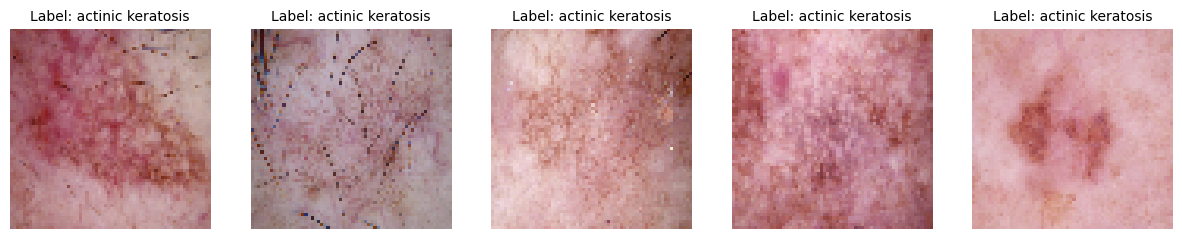

In [2]:
#Let's also see the first 5 images
import matplotlib.pyplot as plt

def display_images(images, labels, le, n=5):
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.set_title(f"Label: {le.inverse_transform([labels[i]])[0]}", fontsize=10)
        ax.axis('off')
    plt.show()

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(list(train_label_map.keys())) #so we can show the labels or each displayed image

display_images(X_train, y_train, le)

In [3]:
#now we normalize the data
X_train = X_train / 255.0 #image pixels are usually between [0 255]
X_test = X_test / 255.0

print(f"Training data: {X_train.shape}, Labels: {y_train.shape}")
print(f"Test data: {X_test.shape}, Labels: {y_test.shape}")
print(f"Label Map: {train_label_map}")

Training data: (2239, 64, 64, 3), Labels: (2239,)
Test data: (118, 64, 64, 3), Labels: (118,)
Label Map: {'actinic keratosis': 0, 'basal cell carcinoma': 1, 'dermatofibroma': 2, 'melanoma': 3, 'nevus': 4, 'pigmented benign keratosis': 5, 'seborrheic keratosis': 6, 'squamous cell carcinoma': 7, 'vascular lesion': 8}


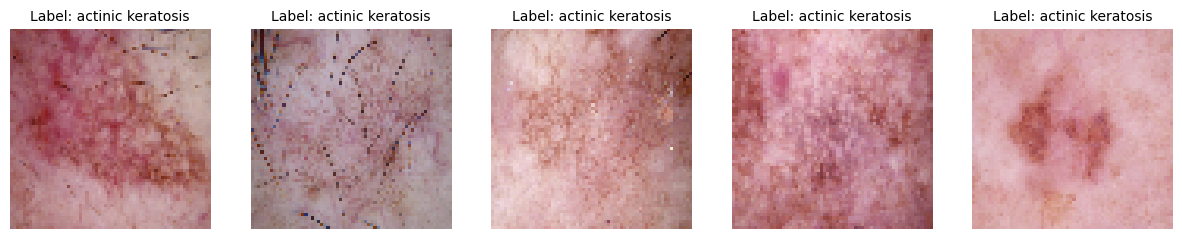

In [4]:
#Let's also show the same images after applying normalization
display_images(X_train, y_train, le)

In [5]:
#feature extraction through HOG (Histogram of Oriented Gradients)

from skimage.feature import hog

# Extract HOG features
def extract_hog_features(images):
    features = []
    for img in images:
        # Convert to grayscale for HOG
        gray = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
        feature = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys')
        features.append(feature)
    return np.array(features)

X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

print(f"Training data: {X_train_hog.shape}, Labels: {y_train.shape}")
print(f"Test data: {X_test_hog.shape}, Labels: {y_test.shape}")

Training data: (2239, 1764), Labels: (2239,)
Test data: (118, 1764), Labels: (118,)


Accuracy: 0.2457627118644068


Accuracy: 0.23728813559322035


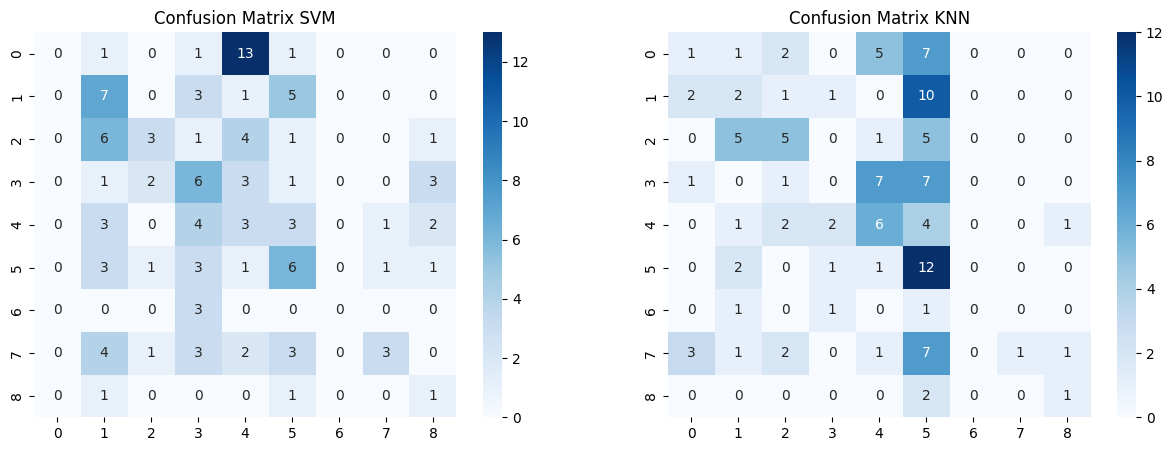

In [14]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Train SVM, KNN and KNN (5 neighbours) classifier
svmClassifier = SVC(kernel='linear', random_state=42)
svmClassifier.fit(X_train_hog, y_train)

KNNclassifier = KNeighborsClassifier(n_neighbors=10)
KNNclassifier.fit(X_train_hog, y_train)



# Evaluate
y_predSVM = svmClassifier.predict(X_test_hog)
print("Accuracy:", accuracy_score(y_test, y_predSVM))
print("\n")
#print("Confusion Matrix SVM:\n",confusion_matrix(y_test, y_predSVM))
#let's show the confusion matrix instead as a heatmap for easier interpretation
SVM_cm = confusion_matrix(y_test, y_predSVM)

ypredKNN = KNNclassifier.predict(X_test_hog)
print("Accuracy:", accuracy_score(y_test, ypredKNN))
#print("Confusion Matrix KNN:\n",confusion_matrix(y_test, ypredKNN))
KNN_cm = confusion_matrix(y_test, ypredKNN)

#Display the two heatmaps:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(SVM_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Confusion Matrix SVM")

sns.heatmap(KNN_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title("Confusion Matrix KNN")

plt.show()

Plot for SVM:



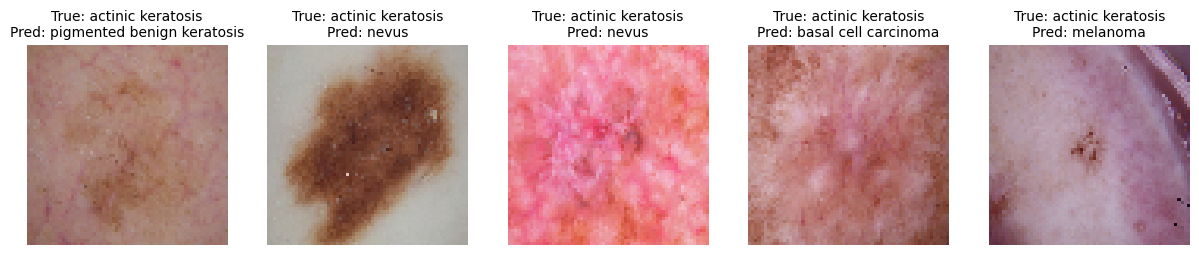

Plot for KNN:



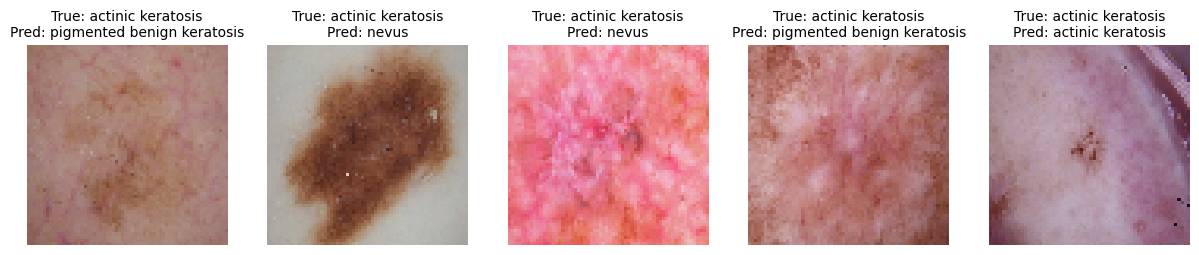

In [15]:
#visualise results
import matplotlib.pyplot as plt

# Plot examples
def plot_results(images, true_labels, pred_labels, le, n=5):
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        title = f"True: {le.inverse_transform([true_labels[i]])[0]}\nPred: {le.inverse_transform([pred_labels[i]])[0]}"
        ax.set_title(title, fontsize=10)
        ax.axis('off')
    plt.show()

print("Plot for SVM:\n")
plot_results(X_test, y_test, y_predSVM, le)

print ("Plot for KNN:\n")
plot_results(X_test, y_test, ypredKNN, le)

